In [1]:
import pickle
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import torch.nn as nn
import torch.optim as optim
from focal_loss.focal_loss import FocalLoss
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler, RandomSampler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
#from autoencoder_utils import *
from isolated_utils import *

In [2]:
# Filepath to embeddings
fname = '/mnt/mimic/data/HAIM/mimic_extras/embeddings.csv'

quantization_config = BitsAndBytesConfig(load_in_4bit=True, 
                                         bnb_4bit_use_double_quant=True,
                                         bnb_4bit_quant_type="nf4",
                                         bnb_4bit_compute_dtype=torch.bfloat16)

tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b")
gemma = AutoModelForCausalLM.from_pretrained("google/gemma-2b", device_map="auto", quantization_config=quantization_config)

# Read data & extract labels and features
df = pd.read_csv(fname)


# Load train/val sets and create data loaders
batch_size = 32

Data = DataSplit(df)
Data.split_data('all')
X, V = Data.get_data()

torch.manual_seed(42)


Data.y_train = Data.y_train.apply(lambda lst: [2 if x == -1 else x for x in lst])
Data.y_val = Data.y_val.apply(lambda lst: [2 if x == -1 else x for x in lst])

train_set = CustomDataset(X.values.tolist(), Data.y_train.tolist())
val_set = CustomDataset(V.values.tolist(), Data.y_val.tolist())

transposed_Y = list(map(list, zip(*Data.y_train.tolist())))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=5)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=5)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/liv/multimodal_healthcare/isolated_utils.py:151: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_death_small48['y'] = 1
/home/liv/multimodal_healthcare/isolated_utils.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alive_big48['y'] = 0
/home/liv/multimodal_healthcare/isolated_utils.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [5]:
# Setting model and hyperparameters
vd_model = torch.load('results/final_models/isolated_assymetric/vd.pth').to('cuda')
vmd_model = torch.load('results/final_models/isolated_assymetric/vmd.pth').to('cuda')

ts_pe_model = torch.load('results/final_models/isolated_assymetric/ts_pe.pth').to('cuda')
ts_ce_model = torch.load('results/final_models/isolated_assymetric/ts_ce.pth').to('cuda')
ts_le_model = torch.load('results/final_models/isolated_assymetric/ts_le.pth').to('cuda')

n_rad_model = torch.load('results/final_models/isolated_assymetric/n_rad.pth').to('cuda')
models = [vd_model, vmd_model, ts_pe_model, ts_ce_model, ts_le_model, n_rad_model]

In [6]:
def output_to_label(logits, labels):

    probs_tensor_pos = F.sigmoid(logits)

    pred = torch.round(probs_tensor_pos)

    probs_tensor_neg = 1-probs_tensor_pos

    prob = torch.stack((probs_tensor_neg, probs_tensor_pos), dim=1)


    return prob, pred, labels

In [7]:
def predict(models, val_loader, gemma):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    per_class_probs = [[] for _ in range(12)]
    per_class_preds = [[] for _ in range(12)]
    per_class_labels = [[] for _ in range(12)]

    for model in models:
        model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x, y.to(device)

            vd_inputs = x['vd'].to(device)
            vmd_inputs = x['vmd'].to(device)
            ts_pe_inputs = x['ts_pe'].to(device)
            ts_ce_inputs = x['ts_ce'].to(device)
            ts_le_inputs = x['ts_le'].to(device)
            n_rad_inputs = x['n_rad'].to(device)

            encoded_vd = models[0].encoder(vd_inputs)
            encoded_vmd = models[1].encoder(vmd_inputs)
            encoded_ts_pe = models[2].encoder(ts_pe_inputs)
            encoded_ts_ce = models[3].encoder(ts_ce_inputs)
            encoded_ts_le = models[4].encoder(ts_le_inputs)
            encoded_n_rad = models[5].encoder(n_rad_inputs)

            decoded_vd = models[0].decoder(encoded_vd)
            decoded_vmd = models[1].decoder(encoded_vmd)
            decoded_ts_pe = models[2].decoder(encoded_ts_pe)
            decoded_ts_ce = models[3].decoder(encoded_ts_ce)
            decoded_ts_le = models[4].decoder(encoded_ts_le)
            decoded_n_rad = models[5].decoder(encoded_n_rad)

            inputs = [vd_inputs, vmd_inputs, ts_pe_inputs, ts_ce_inputs, ts_le_inputs, n_rad_inputs]
            decoded = [decoded_vd, decoded_vmd, decoded_ts_pe, decoded_ts_ce, decoded_ts_le, decoded_n_rad]

            concat_emb = torch.cat((encoded_vd.view(-1,1,2048).to(torch.float16), encoded_vmd.view(-1,1,2048).to(torch.float16), 
                                encoded_ts_pe.view(-1,1,2048).to(torch.float16), encoded_ts_ce.view(-1,1,2048).to(torch.float16), 
                                encoded_ts_le.view(-1,1,2048).to(torch.float16), encoded_n_rad.view(-1,1,2048).to(torch.float16)),
                                  dim=1).to(device)

            logits = custom_output(concat_emb, gemma)

            probabilities, hard_preds, labels = output_to_label(logits, labels)


            for i in range(probabilities.size(2)):
                class_prob = probabilities[:, :, i]  # Select probabilities for class i
                per_class_probs[i].append(probabilities[:, :, i])
                per_class_preds[i].append(hard_preds[:, i])
                per_class_labels[i].append(labels[:, i])


    return per_class_preds, per_class_labels, per_class_probs

In [8]:
per_class_preds, per_class_labels, per_class_probs = predict(models, val_loader, gemma)

In [9]:
f1_scores = []
auc_scores = []
precisions = []
recalls = []
accuracies = []
matrices = []
fpr_tpr = []
roc_aucs = []

for i,class_preds in enumerate(per_class_preds):
    preds = []
    preds = [t.cpu().numpy() for t in class_preds]
    preds = np.concatenate(preds)
    labels = []
    labels = [t.cpu().numpy() for t in per_class_labels[i]]
    labels = np.concatenate(labels)
    stuff = len(per_class_probs[i][0])
    probs = []
    probs = [t.cpu().numpy() for t in per_class_probs[i]]
    probs = np.concatenate(probs, axis=0)
    mask = ~np.isnan(labels) & (labels != 2)
    masked_labels = labels[mask]
    masked_preds = preds[mask]
    masked_probs = probs[mask]
    positive_probs = masked_probs[:, 1]
    f1_scores.append(metrics.f1_score(masked_labels, masked_preds, average='macro'))
    auc_scores.append(metrics.roc_auc_score(masked_labels, positive_probs))
    precisions.append(metrics.precision_score(masked_labels, masked_preds))
    recalls.append(metrics.recall_score(masked_labels, masked_preds))
    accuracies.append(metrics.accuracy_score(masked_labels, masked_preds))
    matrices.append(metrics.confusion_matrix(masked_labels, masked_preds))
    fpr, tpr, thresholds = metrics.roc_curve(masked_labels, positive_probs)
    fpr_tpr.append((fpr,tpr))
    roc_aucs.append(metrics.auc(fpr, tpr))

Class: Fracture
F1 score: 0.5001453065969195
AUC score: 0.5185021376971841
Precision: 0.9390243902439024
Recall: 0.9535603715170279
Accuracy: 0.8982558139534884



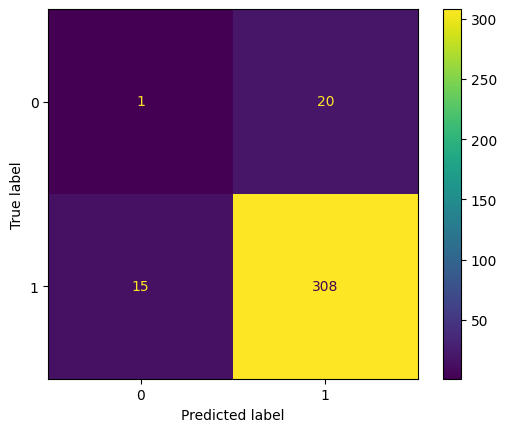

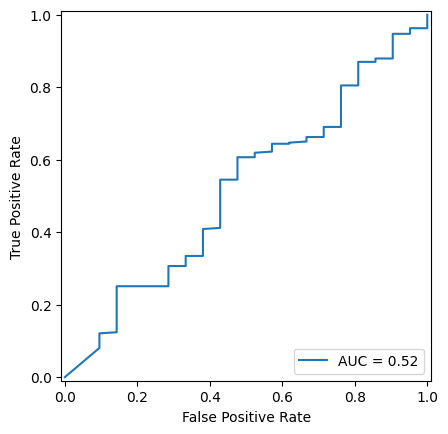

In [10]:
print('Class: Fracture')

print(f'F1 score: {f1_scores[0]}\n'
        f'AUC score: {auc_scores[0]}\n'
        f'Precision: {precisions[0]}\n'
        f'Recall: {recalls[0]}\n'
        f'Accuracy: {accuracies[0]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[0])
matrix.plot()

fpr, tpr = fpr_tpr[0]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[0])
roc_curve.plot()

Class: Lung Lesion
F1 score: 0.47162162162162163
AUC score: 0.6183015440508628
Precision: 0.935656836461126
Recall: 0.9509536784741145
Accuracy: 0.8925831202046036



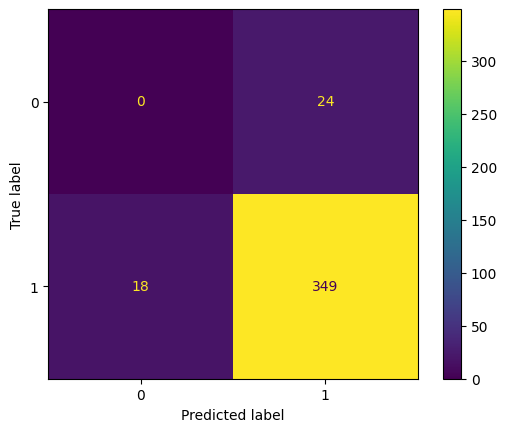

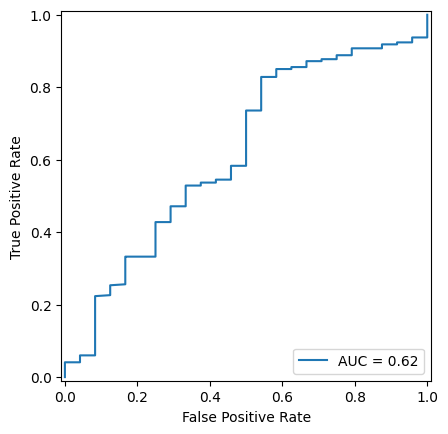

In [11]:
print('Class: Lung Lesion')
print(f'F1 score: {f1_scores[1]}\n'
        f'AUC score: {auc_scores[1]}\n'
        f'Precision: {precisions[1]}\n'
        f'Recall: {recalls[1]}\n'
        f'Accuracy: {accuracies[1]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[1])
matrix.plot()

fpr, tpr = fpr_tpr[1]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[1])
roc_curve.plot()

Class: Enlarged Cardiomediastinum
F1 score: 0.5117256301840247
AUC score: 0.6098640044626541
Precision: 0.7464589235127479
Recall: 0.8717948717948718
Accuracy: 0.6870042708968883



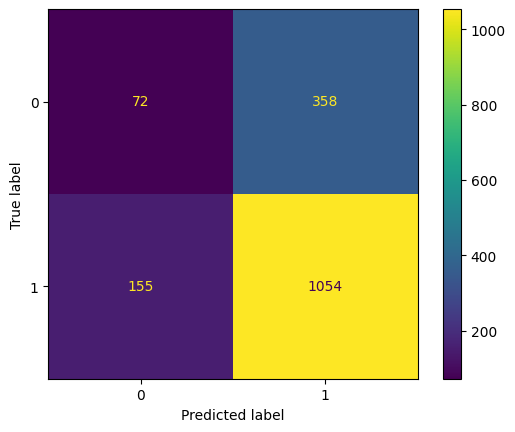

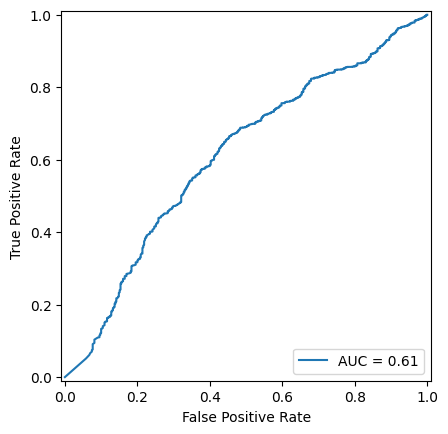

In [12]:
print('Class: Enlarged Cardiomediastinum')
print(f'F1 score: {f1_scores[2]}\n'
        f'AUC score: {auc_scores[2]}\n'
        f'Precision: {precisions[2]}\n'
        f'Recall: {recalls[2]}\n'
        f'Accuracy: {accuracies[2]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[2])
matrix.plot()

fpr, tpr = fpr_tpr[2]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[2])
roc_curve.plot()

Class: Consolidation
F1 score: 0.565596296940988
AUC score: 0.649046349466776
Precision: 0.8535031847133758
Recall: 0.9296947271045328
Accuracy: 0.8078112915699923



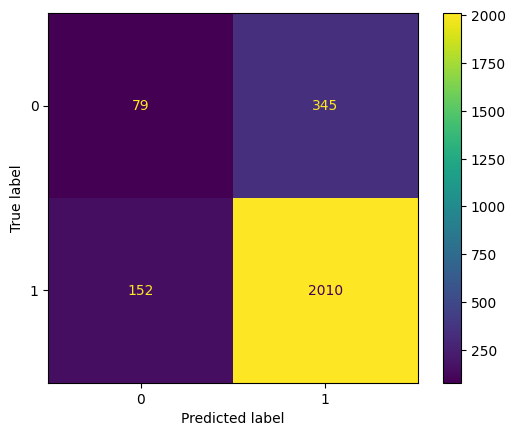

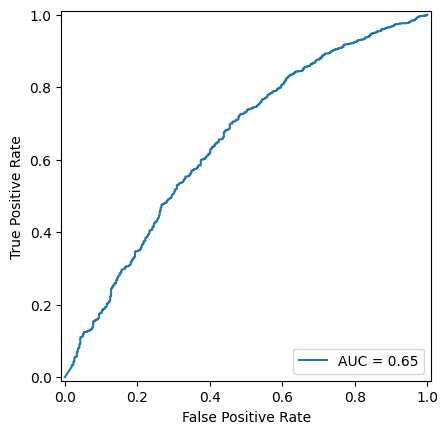

In [13]:
print('Class: Consolidation')
print(f'F1 score: {f1_scores[3]}\n'
        f'AUC score: {auc_scores[3]}\n'
        f'Precision: {precisions[3]}\n'
        f'Recall: {recalls[3]}\n'
        f'Accuracy: {accuracies[3]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[3])
matrix.plot()

fpr, tpr = fpr_tpr[3]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[3])
roc_curve.plot()

Class: Pneumonia
F1 score: 0.48826089323092337
AUC score: 0.6392426029868883
Precision: 0.5739500912964091
Recall: 0.9080404429465575
Accuracy: 0.5786546610169492



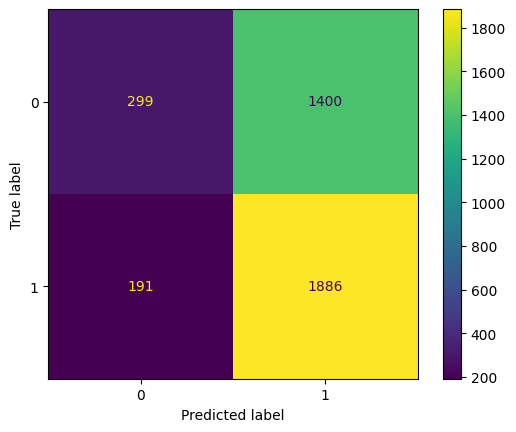

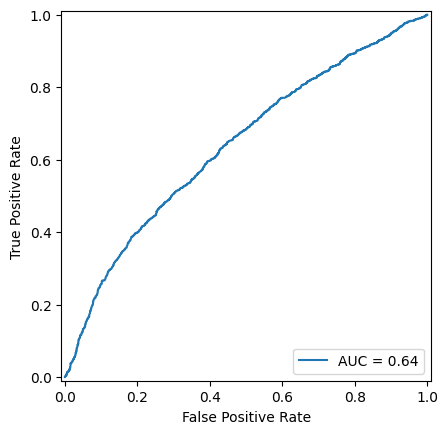

In [14]:
print('Class: Pneumonia')
print(f'F1 score: {f1_scores[4]}\n'
        f'AUC score: {auc_scores[4]}\n'
        f'Precision: {precisions[4]}\n'
        f'Recall: {recalls[4]}\n'
        f'Accuracy: {accuracies[4]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[4])
matrix.plot()

fpr, tpr = fpr_tpr[4]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[4])
roc_curve.plot()

Class: Atelectasis
F1 score: 0.5016289758417427
AUC score: 0.6128135972837556
Precision: 0.9760956175298805
Recall: 0.9947218838814454
Accuracy: 0.9710738343679831



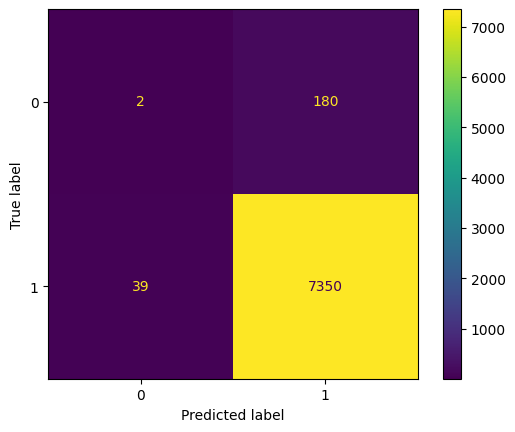

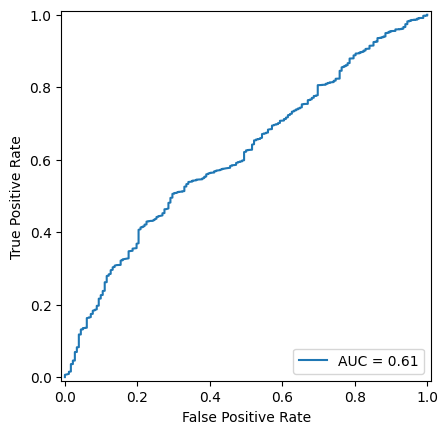

In [15]:
print('Class: Atelectasis')
print(f'F1 score: {f1_scores[5]}\n'
        f'AUC score: {auc_scores[5]}\n'
        f'Precision: {precisions[5]}\n'
        f'Recall: {recalls[5]}\n'
        f'Accuracy: {accuracies[5]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[5])
matrix.plot()

fpr, tpr = fpr_tpr[5]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[5])
roc_curve.plot()

Class: Lung Opacity
F1 score: 0.5070282214905191
AUC score: 0.6050161378419981
Precision: 0.9645152651312265
Recall: 0.98
Accuracy: 0.9459601259181531



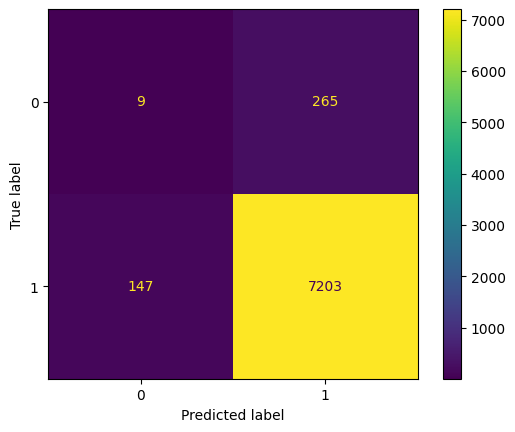

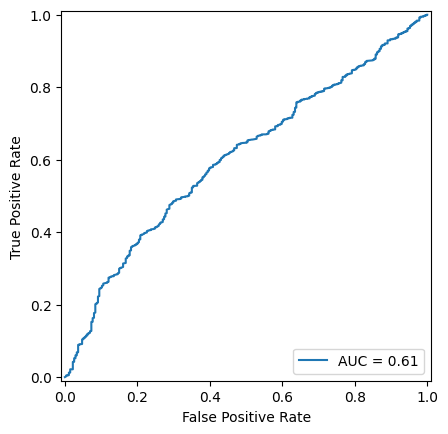

In [16]:
print('Class: Lung Opacity')
print(f'F1 score: {f1_scores[6]}\n'
        f'AUC score: {auc_scores[6]}\n'
        f'Precision: {precisions[6]}\n'
        f'Recall: {recalls[6]}\n'
        f'Accuracy: {accuracies[6]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[6])
matrix.plot()

fpr, tpr = fpr_tpr[6]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[6])
roc_curve.plot()

Class: Pneumothorax
F1 score: 0.4212803068463939
AUC score: 0.6060020948195473
Precision: 0.20570706158569624
Recall: 0.7543046357615895
Accuracy: 0.43788307402168786



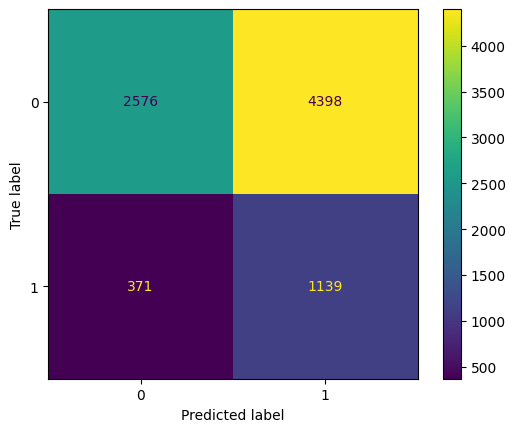

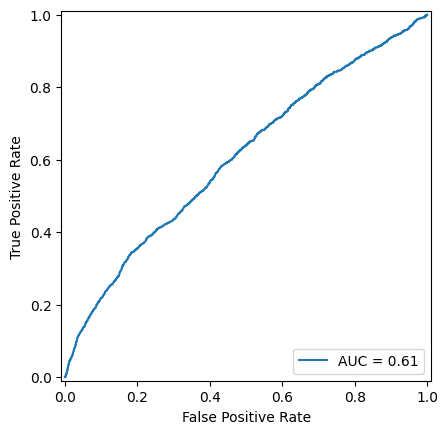

In [15]:
print('Class: Pneumothorax')
print(f'F1 score: {f1_scores[7]}\n'
        f'AUC score: {auc_scores[7]}\n'
        f'Precision: {precisions[7]}\n'
        f'Recall: {recalls[7]}\n'
        f'Accuracy: {accuracies[7]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[7])
matrix.plot()

fpr, tpr = fpr_tpr[7]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[7])
roc_curve.plot()

Class: Edema
F1 score: 0.5179449521785289
AUC score: 0.6223974404250496
Precision: 0.6533687943262412
Recall: 0.8996948118006104
Accuracy: 0.6364916773367477



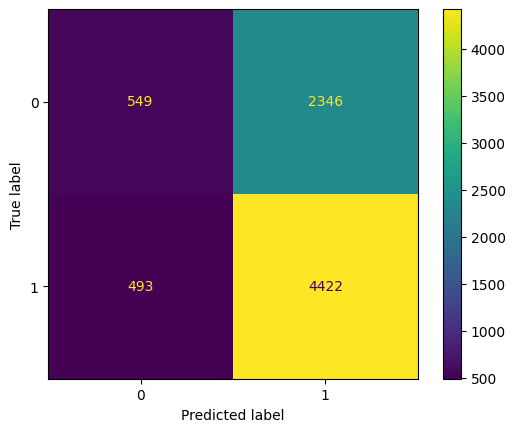

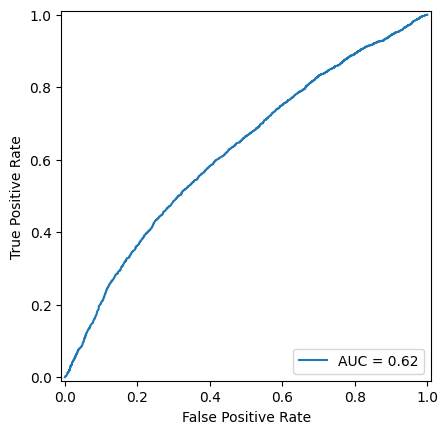

In [17]:
print('Class: Edema')
print(f'F1 score: {f1_scores[8]}\n'
        f'AUC score: {auc_scores[8]}\n'
        f'Precision: {precisions[8]}\n'
        f'Recall: {recalls[8]}\n'
        f'Accuracy: {accuracies[8]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[8])
matrix.plot()

fpr, tpr = fpr_tpr[8]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[8])
roc_curve.plot()

Class: Cardiomegaly
F1 score: 0.506900597221901
AUC score: 0.6253588039864202
Precision: 0.8166585127201565
Recall: 0.956453230196247
Accuracy: 0.790786725458343



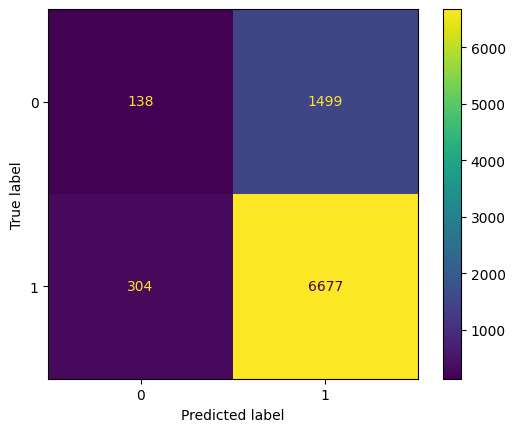

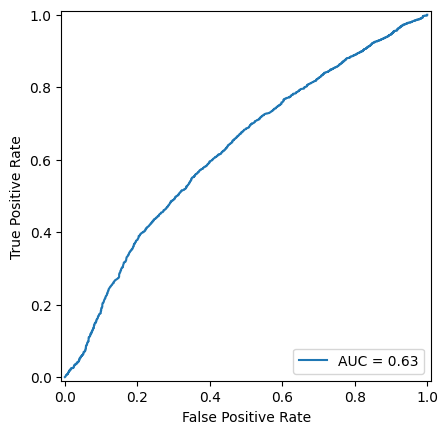

In [18]:
print('Class: Cardiomegaly')
print(f'F1 score: {f1_scores[9]}\n'
        f'AUC score: {auc_scores[9]}\n'
        f'Precision: {precisions[9]}\n'
        f'Recall: {recalls[9]}\n'
        f'Accuracy: {accuracies[9]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[9])
matrix.plot()

fpr, tpr = fpr_tpr[9]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[9])
roc_curve.plot()

Class: Length-of-Stay
F1 score: 0.3491200473300863
AUC score: 0.5674039656136287
Precision: 0.09930873999041819
Recall: 0.6972609322441135
Accuracy: 0.3963139692684849



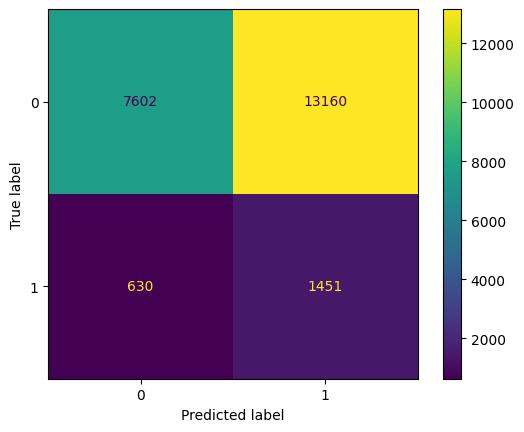

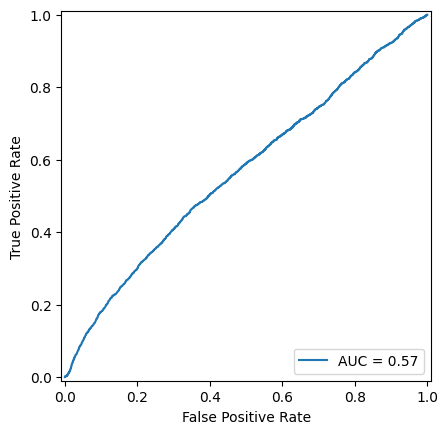

In [19]:
print('Class: Length-of-Stay')
print(f'F1 score: {f1_scores[10]}\n'
        f'AUC score: {auc_scores[10]}\n'
        f'Precision: {precisions[10]}\n'
        f'Recall: {recalls[10]}\n'
        f'Accuracy: {accuracies[10]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[10])
matrix.plot()

fpr, tpr = fpr_tpr[10]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[10])
roc_curve.plot()

Class: 48-hour Mortality
F1 score: 0.34406333212949647
AUC score: 0.5477870578914035
Precision: 0.02259365026037292
Recall: 0.5735607675906184
Accuracy: 0.4818106203213238



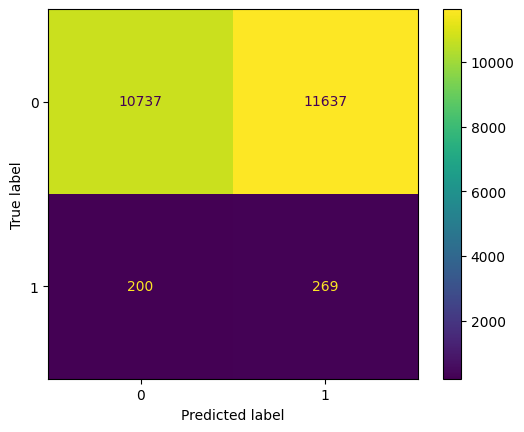

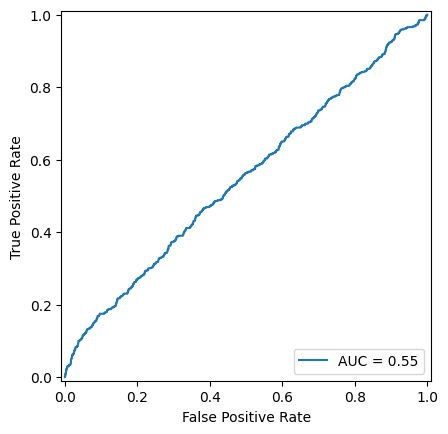

In [20]:
print('Class: 48-hour Mortality')
print(f'F1 score: {f1_scores[11]}\n'
        f'AUC score: {auc_scores[11]}\n'
        f'Precision: {precisions[11]}\n'
        f'Recall: {recalls[11]}\n'
        f'Accuracy: {accuracies[11]}\n')

matrix = metrics.ConfusionMatrixDisplay(confusion_matrix=matrices[11])
matrix.plot()

fpr, tpr = fpr_tpr[11]
roc_curve = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_aucs[11])
roc_curve.plot()